In [75]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import avg as Favg
from pyspark.sql.functions import count as Fcount
from pyspark.sql.functions import countDistinct as FcountDistinct
from pyspark.sql.functions import min as Fmin
from pyspark.sql.functions import max as Fmax
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


plt.rcParams['figure.figsize'] = 13, 7


# Load Dataset

In [76]:
dfpath = '../data/medium-sparkify-event-data.json'
spark = SparkSession\
        .builder\
        .appName('sparkify_etl')\
        .getOrCreate()

df = spark.read.json(dfpath)

# Exploratory Data Analysis

## Investigate columns

In [77]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [78]:
# Remove columns that are unlikely to be valuable
valuable_columns = ['artist', 'auth', 'gender', 'itemInSession', 'level', 'location', 'page', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId']
df = df.select(valuable_columns)

In [79]:
for column in df.columns:
    df.describe(column).show()

+-------+-----------------+
|summary|           artist|
+-------+-----------------+
|  count|           432877|
|   mean|527.5289537712895|
| stddev|966.1072451772758|
|    min|              !!!|
|    max|ÃÂlafur Arnalds|
+-------+-----------------+

+-------+----------+
|summary|      auth|
+-------+----------+
|  count|    543705|
|   mean|      null|
| stddev|      null|
|    min| Cancelled|
|    max|Logged Out|
+-------+----------+

+-------+------+
|summary|gender|
+-------+------+
|  count|528005|
|   mean|  null|
| stddev|  null|
|    min|     F|
|    max|     M|
+-------+------+

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            543705|
|   mean|107.30629109535502|
| stddev|116.72350849188155|
|    min|                 0|
|    max|              1005|
+-------+------------------+

+-------+------+
|summary| level|
+-------+------+
|  count|543705|
|   mean|  null|
| stddev|  null|
|    min|  free|
|    max|  paid|
+----

In [80]:
for column in df.dtypes:
    if column[1] == 'string':
        df.select(column[0]).drop_duplicates().show()

+--------------------+
|              artist|
+--------------------+
|      The Black Keys|
|        Yann Tiersen|
|    Jane's Addiction|
|          Tim Hughes|
|Dashboard Confess...|
|                Silk|
|Yonder Mountain S...|
|            La Shica|
|        Elvis Crespo|
|         Silverstein|
|         Eva Cassidy|
|        Generation X|
|     Robyn Hitchcock|
|           Kate Nash|
|       Jupiter Jones|
|           Los Lobos|
|               Rufio|
|     Drive Like Jehu|
|       Yuichi Tamate|
|      Jarabe De Palo|
+--------------------+
only showing top 20 rows

+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+

+-----+
|level|
+-----+
| free|
| paid|
+-----+

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|        Richmond, VA|
|          Tucson, AZ|
|       Oskaloosa, IA|
|Deltona-Daytona B..

In [81]:
df.select('page').drop_duplicates().show(30)

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
| Submit Registration|
|            Settings|
|               Login|
|            Register|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



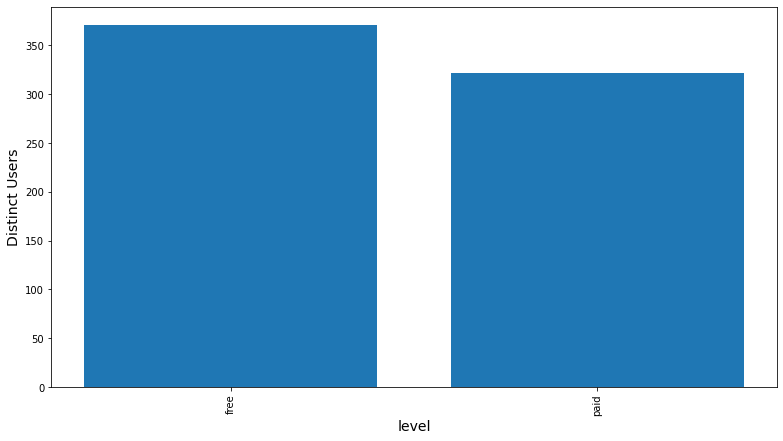

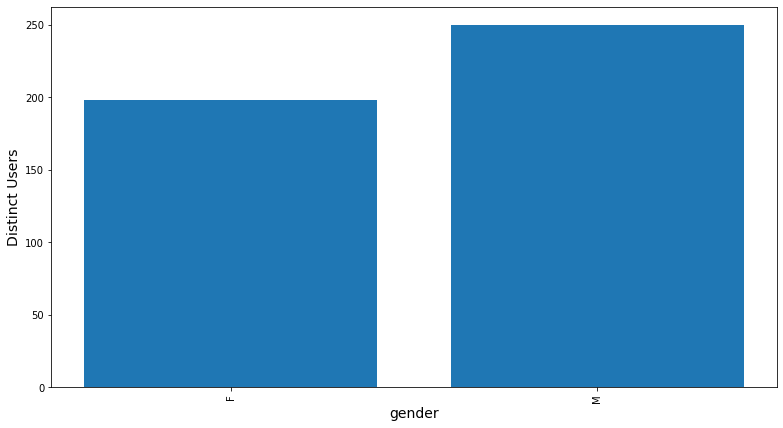

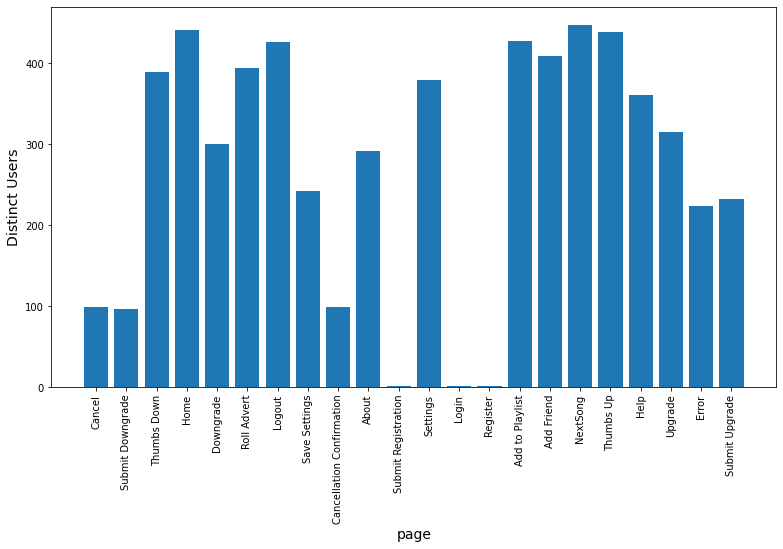

In [82]:
def plot_column(column_name):
    col_summary = df.select(['userId', column_name])\
                    .na.drop()\
                    .groupBy(column_name)\
                    .agg(FcountDistinct(col('userId')).alias('count')) \
                    .collect()
    x_val = [val[0] for val in col_summary]
    y_val = [val[1] for val in col_summary]
    plt.bar(x_val, y_val)
    plt.xlabel(column_name, fontsize = 14)
    plt.ylabel('Distinct Users', fontsize =14)
    plt.xticks(rotation=90)
    plt.show()

columns = ['level', 'gender', 'page']
for column in columns:
    plot_column(column)

## Investigate missing values

In [83]:
df_size = df.count()
missing = {}

for column in df.columns:
    missing_values = ((df_size - df.select(column)\
                                    .filter(df[column].cast(StringType()) != "")\
                                    .na.drop()\
                                    .count()) 
                        / df_size) * 100
    missing[column] = missing_values
    print(f'{column}: {missing_values:.2f} % missing values')

artist: 20.38 % missing values
auth: 0.00 % missing values
gender: 2.89 % missing values
itemInSession: 0.00 % missing values
level: 0.00 % missing values
location: 2.89 % missing values
page: 0.00 % missing values
registration: 2.89 % missing values
sessionId: 0.00 % missing values
song: 20.38 % missing values
status: 0.00 % missing values
ts: 0.00 % missing values
userAgent: 2.89 % missing values
userId: 2.89 % missing values


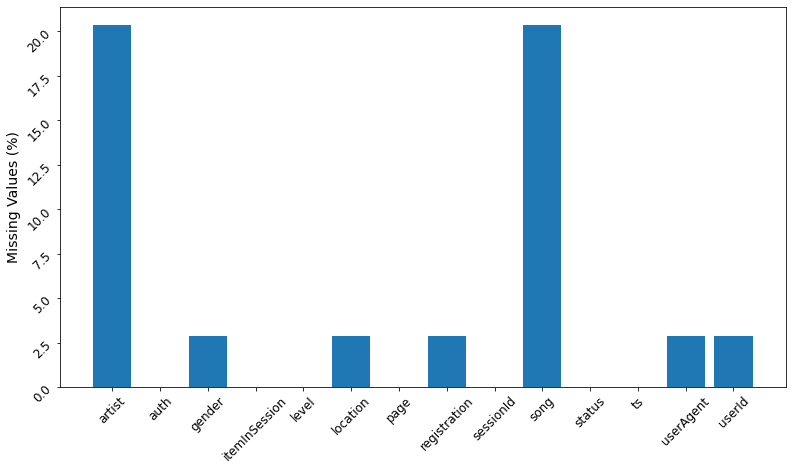

In [84]:
plt.bar(missing.keys(), missing.values())
plt.xticks(rotation=45, fontsize= 12)
plt.yticks(rotation=45, fontsize= 12)
plt.ylabel('Missing Values (%)', fontsize= 14)
plt.show()

In [85]:
df_size = df.filter(df.auth.isin(['Logged Out', 'Guest']) == False).count()

for column in df.columns:
    missing_values = ((df_size - df.filter(df.auth.isin(['Logged Out', 'Guest']) == False)\
                                    .select(column)\
                                    .filter(df[column].cast(StringType()) != "")\
                                    .na.drop()\
                                    .count()) 
                        / df_size) * 100
    print(f'{column}: {missing_values:.2f} % missing values')

artist: 18.02 % missing values
auth: 0.00 % missing values
gender: 0.00 % missing values
itemInSession: 0.00 % missing values
level: 0.00 % missing values
location: 0.00 % missing values
page: 0.00 % missing values
registration: 0.00 % missing values
sessionId: 0.00 % missing values
song: 18.02 % missing values
status: 0.00 % missing values
ts: 0.00 % missing values
userAgent: 0.00 % missing values
userId: 0.00 % missing values


All missing values for the `userId` column are created by users that are either `Logged Out`, or logged in as a `Guest`.

The empty values for `Artist`, `Song` and `Length` are most likely due not no song being played at the time of the event. 

It is also important to note, that the `userId` is sometimes an empty string, not NaN


# Clean data

As there is no value in looking at users that are not logged in for churn analysis - their entries will be disregarded. 
The empty `Artist`, `Song` and `Length` values will not be removed, as the rest of their rows may provide valuable data.

In [86]:
df = df.filter(df.auth.isin(['Logged Out', 'Guest']) == False)

# Feature Engineering

In [87]:
def detect_os(column):
    '''
        summary:
            Transformes the userId userAgent column into the platform used by the user
            * Microsoft
            * Apple
            * Linux
        args:
            column - column to be transformed
        returns:
            Name of the platform used
    '''
    detect = re.findall(r'\((\w+)', column)[0]
    if detect in ['iPhone', 'iPad', 'Macintosh']:
        return 'Apple'
    elif detect in ['Windows', 'compatible']:
        return'Microsoft'
    elif detect in ['X11']:
        return'Linux'
    else:
        return 'Not Detected'

detect_os_udf = udf(detect_os)

# Create platform and age in hours column
df = df.withColumn('platform', detect_os_udf(df.userAgent))\
        .withColumn('ageHours', (df.ts - df.registration)/3600000)\
        .drop('userAgent')

df = df.withColumn('levelNr', when(
    col('level') == 'paid', 1)
    .otherwise(0)
)

## Define and flag churn

Churn defined as having a `Cancellation Confirmation` page visit

In [88]:
flag_cancellation_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df_churn = df.withColumn('ChurnFlag', flag_cancellation_event('page'))
windowed = Window.partitionBy('userId').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
df_churn = df_churn.withColumn('Churned', Fsum('ChurnFlag').over(windowed))
df_churn.filter(df_churn.Churned == 1).show()

+--------------------+---------+------+-------------+-----+--------------------+--------------------+-------------+---------+--------------------+------+-------------+------+--------+------------------+-------+---------+-------+
|              artist|     auth|gender|itemInSession|level|            location|                page| registration|sessionId|                song|status|           ts|userId|platform|          ageHours|levelNr|ChurnFlag|Churned|
+--------------------+---------+------+-------------+-----+--------------------+--------------------+-------------+---------+--------------------+------+-------------+------+--------+------------------+-------+---------+-------+
|                null|Cancelled|     F|           67| free|Bridgeport-Stamfo...|Cancellation Conf...|1538016340000|      166|                null|   200|1539254318000|100010|   Apple| 343.8827777777778|      0|        1|      1|
|                null|Logged In|     F|           66| free|Bridgeport-Stamfo...|    

In [89]:
# Flag the last month of user data per user

user_level = df_churn.groupBy('userId')\
                .agg(
                    Fmax('ts').alias('latestSession'), 
                    Fmax(when(col('ChurnFlag') == 1, col('ts'))).alias('ChurnTime'))
df_churn = df_churn.join(user_level, on= 'userId', how='left')
df_churn = df_churn.withColumn(
    'lastMonth',
        when(col('churned') == 1, (col('ChurnTime') - col('ts')) /3600000 <= 720)
        .otherwise((col('latestSession') - col('ts')) /3600000 <= 720))

In [90]:
# Aggregate on user level

df_last_month = df_churn\
    .filter(col('lastMonth') == True)\
    .groupBy(['userId', 'gender', 'platform', 'Churned'])\
    .agg(
        Favg(col('itemInSession')).alias('avgItemsInSession'),
        Fmax(col('levelNr')).alias('premiumUser'),
        Fmax(col('ageHours')).alias('ageHours'),
        Fsum(when(col('page') == 'NextSong', 1)).alias('songsListened'),
        Fsum(when(col('page') == 'Add to Playlist', 1)).alias('playlistAdditions'),
        Fsum(when(col('page') == 'Thumbs Up', 1)).alias('upVotes'),
        Fsum(when(col('page') == 'Thumbs Down', 1)).alias('downVotes'),
        Fsum(when(col('page') == 'Add Friend', 1)).alias('friendsAdded'),
        Fsum(when(col('page') == 'Error', 1)).alias('errors'),
        Fsum(when(col('page') == 'Help', 1)).alias('help'),
        Fsum(when(col('page') == 'Roll Advert', 1)).alias('adsListened'),
        FcountDistinct(col('sessionId')).alias('sessionCount'),
        FcountDistinct(col('artist')).alias('distinctArtistsListened'),
        FcountDistinct(col('song')).alias('distinctSongsListened')        
    )

df_last_month= df_last_month.fillna({
    'playlistAdditions':0,
    'upVotes':0,
    'downVotes':0,
    'friendsAdded':0,
    'errors':0,
    'help':0,
    'adsListened':0,
    'songsListened':0
})

df_last_month.show()

+------+------+---------+-------+------------------+-----------+------------------+-------------+-----------------+-------+---------+------------+------+----+-----------+------------+-----------------------+---------------------+
|userId|gender| platform|Churned| avgItemsInSession|premiumUser|          ageHours|songsListened|playlistAdditions|upVotes|downVotes|friendsAdded|errors|help|adsListened|sessionCount|distinctArtistsListened|distinctSongsListened|
+------+------+---------+-------+------------------+-----------+------------------+-------------+-----------------+-------+---------+------------+------+----+-----------+------------+-----------------------+---------------------+
|200002|     M|    Apple|      1|54.832911392405066|          1|1279.7555555555555|          310|                6|     15|        5|           2|     0|   1|         11|           5|                    287|                  306|
|100049|     M|    Apple|      1| 63.91210613598673|          1|1219.99444444444

In [91]:
# Aggregate on group level to find meaningful features

df_last_month.groupBy('Churned')\
    .agg(
        Fcount('userId').alias('total'),
        Fsum(when(col('gender') == 'M', '1')).alias('male'),
        Fsum(when(col('gender') == 'F', '1')).alias('female'),
        Fsum(when(col('platform') == 'Apple', '1')).alias('apple'),
        Fsum(when(col('platform') == 'Microsoft', '1')).alias('Microsoft'),
        Fsum(when(col('platform') == 'Linux', '1')).alias('Linux'),
        Favg('avgItemsInSession').alias('avgItemsInSession'),
        Favg('premiumUser').alias('premiumUserFraction'),
        Favg('ageHours').alias('averageAgeHours'),
        Favg('songsListened').alias('averageSongsListened'),
        Favg('distinctSongsListened').alias('averageDistinctSongsListened'),
        Favg('distinctArtistsListened').alias('averageDistinctArtistsListened'),
        Favg('playlistAdditions').alias('averagePlaylistAdditions'),
        Favg('upVotes').alias('averageUpVotes'),
        Favg('downVotes').alias('averageDownVotes'),
        Favg('friendsAdded').alias('averageFriendsAdded'),
        Favg('errors').alias('averageErrors')
    ).show()

+-------+-----+-----+------+-----+---------+-----+-----------------+-------------------+------------------+--------------------+----------------------------+------------------------------+------------------------+------------------+-----------------+-------------------+------------------+
|Churned|total| male|female|apple|Microsoft|Linux|avgItemsInSession|premiumUserFraction|   averageAgeHours|averageSongsListened|averageDistinctSongsListened|averageDistinctArtistsListened|averagePlaylistAdditions|    averageUpVotes| averageDownVotes|averageFriendsAdded|     averageErrors|
+-------+-----+-----+------+-----+---------+-----+-----------------+-------------------+------------------+--------------------+----------------------------+------------------------------+------------------------+------------------+-----------------+-------------------+------------------+
|      0|  349|196.0| 153.0|154.0|    174.0| 21.0|76.39518797097304| 0.6905444126074498|2089.1691411970705|   590.9426934097421|  

## EDA & Feature Engineering results

|         | Not Churned | Churned |
|---------|-------------|---------|
| female  | 44%         | 45%     |
| apple   | 44%         | 46,5%   |
| Windows | 49.9%       | 48.5%   |
| Linux   | 6.1%        | 5%      |

* It does not look like gender has an influence on churn.
* apple users are slightly more likely to churn compared to Linux and Windows users.
* Churned users seem to be slightly more engaged, having a higher percentage of premium users, more items per session, songs listened and votes in general. 
* The one thing that stands out is that they have way give way more Down Votes on average. 
* They seem to be relatively newer to the service than the non churned users.

## Select and transform valuable features

* Platform
* Level
* User Age
* Songs listened
* Down Votes

In [92]:
features = ['label', 'platformIndexed', 'premiumUser', 'ageHours', 'songsListened', 'downVotes']

indexer = StringIndexer(inputCol='platform', outputCol='platformIndexed')
df_user = indexer.fit(df_last_month)\
            .transform(df_last_month)\
            .withColumnRenamed('Churned', 'label')\
            .select(features)

df_user.show()

+-----+---------------+-----------+------------------+-------------+---------+
|label|platformIndexed|premiumUser|          ageHours|songsListened|downVotes|
+-----+---------------+-----------+------------------+-------------+---------+
|    1|            1.0|          1|1279.7555555555555|          310|        5|
|    1|            1.0|          1|1219.9944444444445|          465|        5|
|    0|            0.0|          1|1892.6022222222223|          296|        3|
|    0|            1.0|          0|2381.4780555555553|           12|        1|
|    0|            1.0|          1|3035.9777777777776|          935|       13|
|    1|            1.0|          0|1274.4994444444444|           39|        0|
|    0|            1.0|          1|1385.7516666666668|           94|        2|
|    0|            1.0|          1|1924.1805555555557|          419|        7|
|    0|            1.0|          1|1787.1402777777778|         1831|       24|
|    1|            0.0|          0| 811.958055555555

# Modeling

In [93]:
train, test = df_user.randomSplit([0.8, 0.2], 23)

feature_names = ['platformIndexed', 'premiumUser', 'ageHours', 'songsListened', 'downVotes']
assembler = VectorAssembler(inputCols = feature_names, outputCol = 'features_vectorized')
scaler = MinMaxScaler(inputCol = 'features_vectorized', outputCol = 'features')

In [94]:
def run_pipeline(model, param_grid, data):
    '''
        summary:
            Runs the pipeline for the provided model based on the provided parameter grid.
        args:
            model - model to be trained
            param_grid - parameter grid that is to be evaluated
            data - training data set to use
        returns:
            trained_model - the trained model
    '''
    pipeline = Pipeline(stages = [assembler, scaler, model])
    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=param_grid,
        evaluator=MulticlassClassificationEvaluator(metricName='f1'),
        numFolds=3)
    trained_model = crossval.fit(data)
    return trained_model

def evaluate_model(model, data):
    '''
        summary:
            Evaluates the performance of a model using the f1-score.
            f1-score is chosen as it provides a good balance between
            recall and precision.
        args:
            model - model to be evaluated
            data - test data set to use
        returns:
            score - f1-score of the model
            confustion_matrix - confusion matrix of the model
    '''
    evaluator = MulticlassClassificationEvaluator(metricName= 'f1')
    predictions = model.transform(data)

    score = evaluator.evaluate(predictions)
    confusion_matrix = predictions.groupby('label')\
                        .pivot('prediction')\
                        .count()\
                        .toPandas()
    return score, confusion_matrix

## Model 1: Logistic Regression

In [100]:
lr = LogisticRegression(maxIter = 10, regParam=0.0, elasticNetParam=0)

param_grid = ParamGridBuilder()\
                .addGrid(lr.maxIter, [10, 5])\
                .build()
lr_model = run_pipeline(lr, param_grid, train)

lr_score, lr_confusion = evaluate_model(lr_model, test)
print(f'The score for the logistic regression is {lr_score:.4f}')
print(lr_confusion)

The score for the logistic regression is 0.7224
   label  0.0  1.0
0      0   63  NaN
1      1   16  1.0


## Model 2: Random Forest

In [101]:
rf = RandomForestClassifier(numTrees=20, featureSubsetStrategy='auto')

param_grid = ParamGridBuilder()\
                .addGrid(rf.numTrees, [5,10,15])\
                .addGrid(rf.maxBins, [4,8,16])\
                .build()

rf_model = run_pipeline(rf, param_grid, train)

rf_score, rf_confusion = evaluate_model(rf_model, test)
print(f'The score for the random forest is {rf_score:.4f}')
print(lr_confusion)

print(f'Best numTrees: {rf_model.bestModel.stages[2].getNumTrees}')
print(f'Best maxBins: {rf_model.bestModel.stages[2].getMaxBins()}')

The score for the random forest is 0.8033
   label  0.0  1.0
0      0   63  NaN
1      1   16  1.0
Best numTrees: 15
Best maxBins: 16


## Model 3: Gradient Boost Classifier

In [97]:
gb = GBTClassifier()

param_grid = ParamGridBuilder()\
                .addGrid(gb.maxIter, [5, 10, 15])\
                .addGrid(gb.stepSize, [0.01, 0.1, 0.2])\
                .build()

gb_model = run_pipeline(gb, param_grid, train)

gb_score, gb_confusion = evaluate_model(gb_model, test)
print(f'The score for the gradient boost is {gb_score:.4f}')
print(gb_confusion)

print(f'Best maxIter: {gb_model.bestModel.stages[2].getMaxIter()}')
print(f'Best stepSize: {gb_model.bestModel.stages[2].getStepSize()}')

The score for the gradient boost is 0.7560
   label  0.0  1.0
0      0   57    6
1      1   12    5
Best maxIter: 5
Best stepSize: 0.2


## Model 4: Multilayer Perceptron

In [98]:
mp = MultilayerPerceptronClassifier()

param_grid = ParamGridBuilder()\
                .addGrid(mp.layers, [[5, 6, 5, 2], [5, 4, 4, 2], [5, 4, 2]])\
                .addGrid(mp.blockSize, [32, 64, 128])\
                .build()

mp_model = run_pipeline(mp, param_grid, train)

mp_score, mp_confusion = evaluate_model(mp_model, test)
print(f'The score for the multiplayer perceptron is {mp_score:.4f}')
print(mp_confusion)

print(f'Best layer configuration: {mp_model.bestModel.stages[2].getLayers()}')
print(f'Best block size: {mp_model.bestModel.stages[2].getBlockSize()}')

The score for the multiplayer perceptron is 0.7948
   label  0.0  1.0
0      0   63  NaN
1      1   13  4.0
Best layer configuration: [5, 4, 2]
Best block size: 32


# Closing words

The multilayer perceptron seems to be performing the best on the small dataset used here with an f1-score of 0.795 and a favorable confusion matrix. 
The configuration used to achieve these results are :
* 5 nodes in the input layer
* 4 nodes in the first intermediate layer
* 2 nodes in the output layer
* A block size of 32

This configuration should be used to train and evaluate the model on the entire dataset as well.